## Notebook: Unsupervised learning


In this notebook, you will learn how to use unsupervised learning to discover  patterns in text.

We cover:
- Co-occurrence: the basic building block  
- LDA: classic topic modeling with word co-occurrence  
- BERTopic: transformer-based topic modeling with embeddings and clustering

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/merged_scopus.csv")

valid_types = ['Article', 'Book', 'Book chapter', 'Review']
df = df[df['Document Type'].isin(valid_types)]

df['text'] = df['Title'].fillna('') + '. ' + df['Abstract'].fillna('')

### Word co-occurrence

In [3]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=250)
X = vectorizer.fit_transform(df['text'])

# Raw co-occurrence matrix
co_matrix = (X.T @ X).toarray()
co_df = pd.DataFrame(co_matrix, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
co_df


,19,2019,2020,2021,2022,2023,2024,2025,academic,access,...,use,used,user,users,using,value,various,work,world,years
19,12542,485,1739,1078,845,510,270,113,162,275,...,977,1366,297,801,2311,190,465,524,576,204
2019,485,920,210,126,148,117,77,21,65,61,...,255,288,72,155,473,90,97,103,82,133
2020,1739,210,1425,316,217,152,72,29,56,124,...,441,456,95,229,788,92,158,143,140,186
2021,1078,126,316,1186,176,129,74,29,83,92,...,396,438,108,208,690,119,189,152,140,167
2022,845,148,217,176,1245,179,139,64,78,95,...,448,460,103,209,786,102,154,131,109,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
value,190,90,92,119,102,141,153,90,119,44,...,293,330,144,130,600,1780,162,135,61,70
various,465,97,158,189,154,200,239,134,132,116,...,457,440,192,200,897,162,1399,193,181,151
work,524,103,143,152,131,151,199,101,122,146,...,580,392,171,223,780,135,193,1852,140,98
world,576,82,140,140,109,104,105,83,51,72,...,262,274,160,134,484,61,181,140,857,80



### Normalization for word frequency.


In [4]:

import numpy as np

N = X.shape[0]
word1, word2 = 'policy', 'analysis'
i, j = vectorizer.vocabulary_.get(word1), vectorizer.vocabulary_.get(word2)

if i is not None and j is not None:
    p_xy = co_matrix[i, j] / N
    p_x = X[:, i].sum() / N
    p_y = X[:, j].sum() / N
    pmi = np.log2(p_xy / (p_x * p_y))
    print(f"Point-wise mutual information ({word1}, {word2}) = {pmi:.3f}")
else:
    print("Words not found.")


Point-wise mutual information (policy, analysis) = 0.045



### Co-occurrence graph

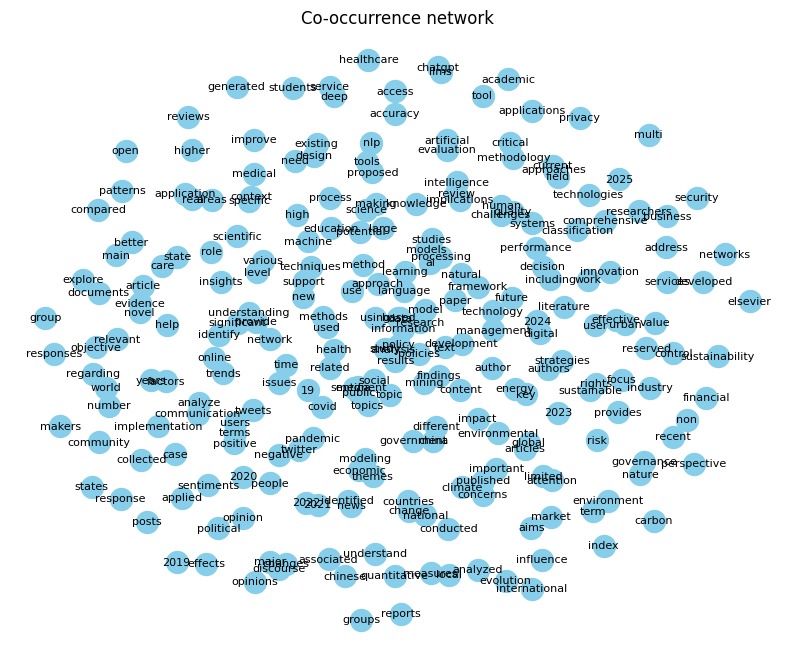

In [5]:
import networkx as nx

G = nx.Graph()
threshold = 50

for w1 in co_df.columns:
    for w2 in co_df.columns:
        if w1 != w2 and co_df.loc[w1, w2] > threshold:
            G.add_edge(w1, w2, weight=co_df.loc[w1, w2])

pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=250, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Co-occurrence network")
plt.axis('off')
plt.show()


## LDA topic modeling

In [6]:
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

texts = []
for doc in df['text']:
    tokens = doc.lower().split()
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 2]
    texts.append(tokens)
    
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=5)
lda_model.print_topics(num_topics=5, num_words=10)

[(0,
  '0.014*"public" + 0.012*"social" + 0.011*"health" + 0.011*"sentiment" + 0.009*"data" + 0.008*"analysis" + 0.008*"covid-19" + 0.008*"media" + 0.006*"study" + 0.006*"tweets"'),
 (1,
  '0.015*"research" + 0.013*"policy" + 0.006*"analysis" + 0.006*"data" + 0.005*"development" + 0.005*"technology" + 0.005*"study" + 0.005*"text" + 0.005*"policies" + 0.004*"mining"'),
 (2,
  '0.007*"sentiment" + 0.006*"data" + 0.005*"analysis" + 0.004*"learning" + 0.004*"model" + 0.004*"study" + 0.004*"information" + 0.004*"language" + 0.004*"policy" + 0.004*"text"'),
 (3,
  '0.010*"learning" + 0.008*"language" + 0.007*"model" + 0.007*"policy" + 0.005*"natural" + 0.005*"deep" + 0.004*"privacy" + 0.004*"based" + 0.004*"proposed" + 0.004*"network"'),
 (4,
  '0.012*"policy" + 0.008*"analysis" + 0.007*"social" + 0.006*"study" + 0.005*"media" + 0.005*"text" + 0.005*"public" + 0.004*"data" + 0.004*"topic" + 0.004*"research"')]

In [7]:
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
print(f"Coherence: {coherence_model.get_coherence():.3f}")

# Gensim log perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Log Perplexity: {perplexity:.3f}  (lower is better)")

Coherence: 0.387
Log Perplexity: -8.918  (lower is better)


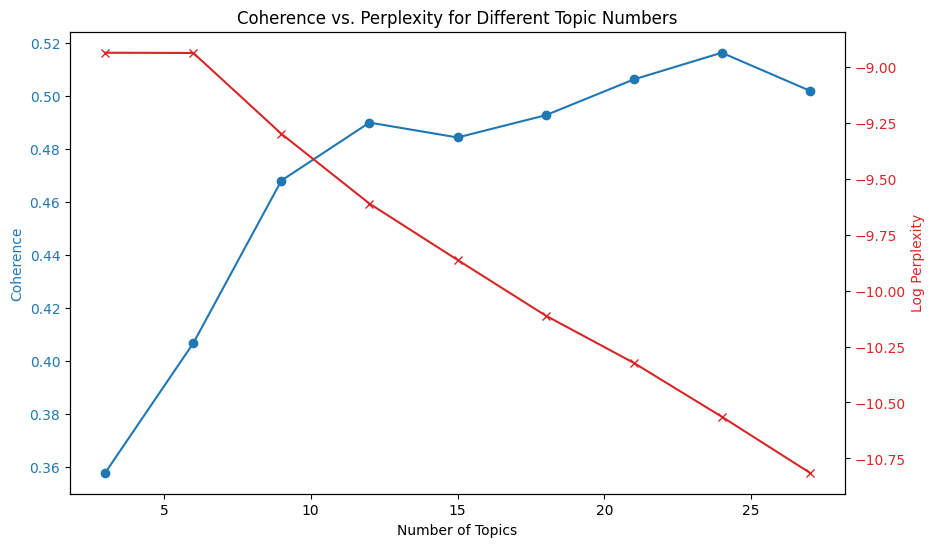

In [8]:
# Range of topic numbers
topic_nums = list(range(3, 30, 3))  # starts at 3, step 3
coherences = []
perplexities = []

for n in topic_nums:
    temp_model = models.LdaModel(corpus=corpus, num_topics=n, id2word=dictionary, passes=5)
    coh = CoherenceModel(model=temp_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    perp = temp_model.log_perplexity(corpus)
    coherences.append(coh)
    perplexities.append(perp)
    #print(f"Topics: {n} | Coherence: {coh:.3f} | Log Perplexity: {perp:.3f}")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(topic_nums, coherences, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add a second y-axis for perplexity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Perplexity', color=color)
ax2.plot(topic_nums, perplexities, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Coherence vs. Perplexity for Different Topic Numbers')
plt.show()

### Interactive LDAVis

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

lda_model = models.LdaModel(corpus=corpus, num_topics=21, id2word=dictionary, passes=5)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.286479 -0.090483       1        1  18.622982
14    -0.268189 -0.049403       2        1  15.710146
2     -0.250301 -0.096483       3        1  13.459104
11    -0.256112  0.161423       4        1  12.323099
20    -0.262091 -0.078375       5        1  11.299401
9     -0.226326  0.026058       6        1  10.655574
8     -0.253224  0.068649       7        1   6.557751
15    -0.164958 -0.081457       8        1   4.719594
16    -0.019642  0.228321       9        1   1.585541
4      0.030435  0.099263      10        1   1.206854
12     0.126381 -0.065404      11        1   0.584281
18     0.140334  0.026732      12        1   0.482942
13     0.171447 -0.014816      13        1   0.446156
3      0.179492 -0.048733      14        1   0.406741
0      0.158500 -0.037917      15        1   0.400816
17     0.165645 -0.004062      16        1   0.393112
5      0.203557 -0.013215      17        1   0.285483
1      0.201368 -0.014806      18        1   0.244169
10     0.199648 -0.014802      19        1   0.220416
7      0.205452 -0.000137      20        1   0.198497
19     0.205065 -0.000354      21        1   0.197339, topic_info=              Term         Freq        Total Category  logprob  loglift
256      sentiment  3082.000000  3082.000000  Default  30.0000  30.0000
124         policy  7430.000000  7430.000000  Default  29.0000  29.0000
1662        health  2422.000000  2422.000000  Default  28.0000  28.0000
565         public  4107.000000  4107.000000  Default  27.0000  27.0000
102       learning  1910.000000  1910.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
15849  annotations     3.105353    16.345175  Topic21  -6.1737   4.5672
16378         al.,     3.578610    54.983822  Topic21  -6.0318   3.4959
32082          as,     2.184689     6.306559  Topic21  -6.5253   5.1679
5904    annotation     2.383815    53.963301  Topic21  -6.4381   3.1084
27226    specialty     2.104023    15.212243  Topic21  -6.5630   4.2498

[1360 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
12787     21  0.867343     (csr)
7710       4  0.074059     (drl)
7710       9  0.888709     (drl)
31938     11  0.765395     (ecb)
9131      13  0.895444     (ehr)
...      ...       ...       ...
3684       2  0.980074   youtube
3684       8  0.010538   youtube
2783      15  0.928868     zero.
10324      1  0.957821  “climate
27469     17  0.686388   “double

[3963 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 3, 12, 21, 10, 9, 16, 17, 5, 13, 19, 14, 4, 1, 18, 6, 2, 11, 8, 20])

In [10]:
topics_per_doc = [sorted(lda_model[doc], key=lambda x: -x[1])[0][0] for doc in corpus]
df['Dominant_Topic'] = topics_per_doc
df[['text', 'Dominant_Topic']].head()

,text,Dominant_Topic
0,Unveiling sustainable tourism themes with mach...,20
15,Investigating the higher education institution...,9
17,Integrating sustainability into cybersecurity:...,11
18,DrugGen enhances drug discovery with large lan...,4
20,Neural topic modeling reveals German televisio...,6


## BERTopic

In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

docs = df['text'].tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

print(f"Shape of embeddings: {embeddings.shape}")

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    min_topic_size=20  # Adjust as needed
)

topics, probs = topic_model.fit_transform(docs, embeddings)

topic_model.get_topic_info().head(10)

/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/Users/esalasgirones/Documents/work/courses/nlp_icpp/.venv/lib/python3.11/site-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
Batches: 100%|██████████| 158/158 [00:15<00:00, 10.09it/s]


Shape of embeddings: (5039, 384)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2029,-1_data_analysis_policy_research,"[data, analysis, policy, research, study, publ...",[Mapping 2 Decades of Research in Health Servi...
1,0,375,0_political_policy_analysis_parties,"[political, policy, analysis, parties, media, ...",[Setting the Agenda or Responding to Voters? P...
2,1,301,1_innovation_technology_research_patent,"[innovation, technology, research, patent, tec...",[A study on the knowledge spillover effect of ...
3,2,219,2_learning_reinforcement_reinforcement learnin...,"[learning, reinforcement, reinforcement learni...",[A Survey on Deep Reinforcement Learning. Deep...
4,3,178,3_sentiment_sentiment analysis_analysis_opinion,"[sentiment, sentiment analysis, analysis, opin...",[A hybrid transformer and attention based recu...
5,4,137,4_bank_monetary_central_monetary policy,"[bank, monetary, central, monetary policy, cen...",[How central bank independence shapes monetary...
6,5,136,5_students_ai_learning_education,"[students, ai, learning, education, educationa...",[Academic Integrity considerations of AI Large...
7,6,134,6_policy_policies_chinas_china,"[policy, policies, chinas, china, development,...",[Quantitative evaluation of China's energy sup...
8,7,126,7_ai_healthcare_medical_artificial,"[ai, healthcare, medical, artificial, artifici...",[Current applications of artificial intelligen...
9,8,105,8_climate_energy_climate change_change,"[climate, energy, climate change, change, medi...",[Text Mining and Sentiment Analysis in Climate...


In [12]:
# Representative docs
topic_nr = 1
reps = topic_model.get_representative_docs(topic_nr)
for doc in reps[:3]:
    print("---")
    print(doc)

---
A study on the knowledge spillover effect of enterprise basic research; [企业基础研究的知识溢出效应研究]. Enterprise basic research on enterprises is an important cornerstone of the construction of a technological country, which helps to promote the deep integration of scientific research and industrial development. Compared with developed countries, there exist a lack of basic research investment in Chinese enterprise. To improve enterprise’s investment in basic research is vital for indigenous innovation in China. Based on the perspective of knowledge spillover, this study constructs the correlation data between science publication and patent science citations of Chinese manufacturing listed companies from 2000 to 2022, exploring the knowledge spillover mechanism of enterprise technology literature on focal enterprise patents and on competitive enterprise patents. We suggest that basic research can be viewed as the input of applied research and development. However, knowledge spillover may resu

In [13]:
# Visualize topics
topic_model.visualize_topics()

In [14]:
# Visualize barchart
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_document_datamap(docs, embeddings=embeddings)